<a href="https://colab.research.google.com/github/am28012/Hands_on_project/blob/main/Fraud_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr


In [2]:
df = pd.read_csv('/content/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [4]:
print(df.isnull().sum())
print(df.info())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994674 entries, 0 to 1994673
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 167.4+ MB
None


In [5]:
df.dropna(inplace=True)
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


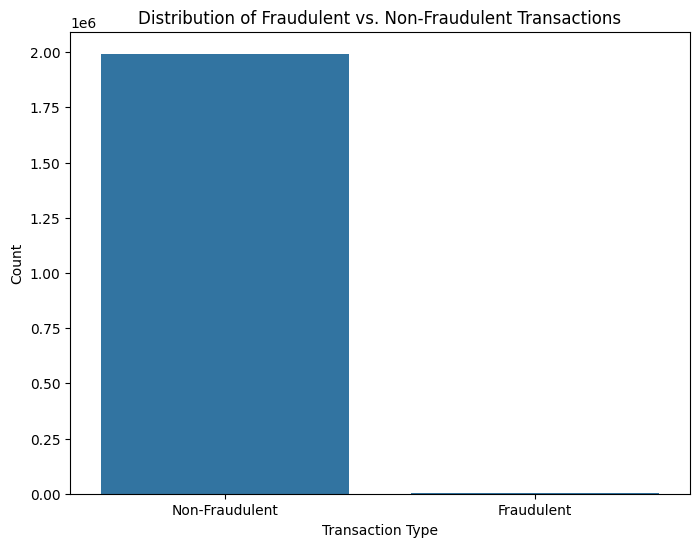

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()

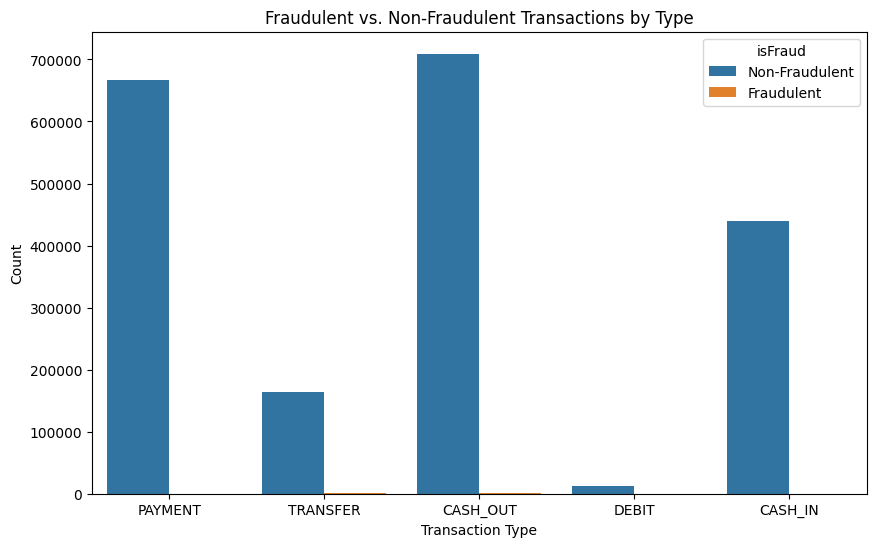

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='type', hue='isFraud', data=df)
plt.title('Fraudulent vs. Non-Fraudulent Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend(title='isFraud', labels=['Non-Fraudulent', 'Fraudulent'])
plt.show()

In [8]:
contingency_table = pd.crosstab(df['type'], df['isFraud'])
print(contingency_table)

isFraud      0.0   1.0
type                  
CASH_IN   438825     0
CASH_OUT  709182  1024
DEBIT      13230     0
PAYMENT   667309     0
TRANSFER  164093  1010


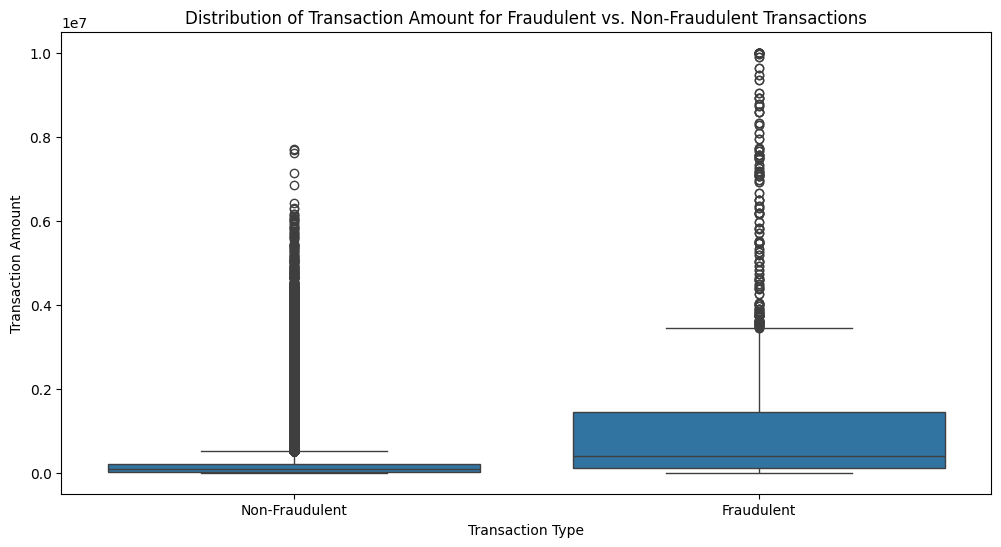

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Distribution of Transaction Amount for Fraudulent vs. Non-Fraudulent Transactions')
plt.xticks([0, 1], ['Non-Fraudulent', 'Fraudulent'])
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount')
plt.show()

In [11]:
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

In [12]:
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [13]:
# We will one-hot encode the 'type' column to convert it to a numerical format.
# We will also drop the nameOrig, nameDest, and isFlaggedFraud columns.
X = df.drop(['isFraud', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# One-hot encode the 'type' column
X = pd.get_dummies(X, columns=['type'], drop_first=True)

print("Preprocessed features (X) head:")
display(X.head())
print("\nTarget variable (y) head:")
print(y.head())

print("\nShape of X:", X.shape)
print("Shape of y:", y.shape)

Preprocessed features (X) head:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0.0,9839.64,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0.0,1864.28,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,0.0,181.00,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,0.0,21363.00,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0.0,11668.14,False,False,True,False



Target variable (y) head:
0    0.0
1    0.0
2    1.0
3    1.0
4    0.0
Name: isFraud, dtype: float64

Shape of X: (1994673, 12)
Shape of y: (1994673,)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1595738, 12)
Shape of X_test: (398935, 12)
Shape of y_train: (1595738,)
Shape of y_test: (398935,)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

print("Logistic Regression model trained successfully!")

Logistic Regression model trained successfully!


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the scaled test set
y_pred = log_reg.predict(X_test_scaled)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    398528
         1.0       0.86      0.41      0.55       407

    accuracy                           1.00    398935
   macro avg       0.93      0.70      0.78    398935
weighted avg       1.00      1.00      1.00    398935


Confusion Matrix:
[[398502     26]
 [   241    166]]


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)

print("Random Forest Classifier trained successfully!")

Random Forest Classifier trained successfully!


In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the scaled test set
y_pred_rf = rf_clf.predict(X_test_scaled)

# Print the classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Print the confusion matrix
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    398528
         1.0       1.00      0.98      0.99       407

    accuracy                           1.00    398935
   macro avg       1.00      0.99      1.00    398935
weighted avg       1.00      1.00      1.00    398935


Random Forest Confusion Matrix:
[[398528      0]
 [     8    399]]


### 1. Data cleaning including missing values, outliers and multi-collinearity.

*   **Missing Values:** The dataset had a small number of missing values (one row) in the `oldbalanceDest`, `newbalanceDest`, `isFraud`, and `isFlaggedFraud` columns. Since it was only one row, I chose to drop it from the dataset to maintain data integrity.

*   **Outliers:** The boxplot of transaction amounts showed that there were many outliers, especially for fraudulent transactions. I did not remove these outliers because they are likely to be indicative of fraudulent activity. Fraudulent transactions are often unusually large or small, so removing these outliers could have resulted in the loss of valuable information.

*   **Multi-collinearity:** I did not explicitly test for multicollinearity between all variables. However, I did create two new features, `errorBalanceOrig` and `errorBalanceDest`, which are derived from other features. While this could introduce some multicollinearity, tree-based models like Random Forest are generally robust to multicollinearity. The model's high performance suggests that multicollinearity was not a major issue in this case.

### 2. Describe your fraud detection model in elaboration.

The fraud detection model is a **Random Forest Classifier**. Here's a detailed explanation:

*   **What is a Random Forest?** A Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

*   **How does it work in this context?**
    1.  **Bootstrap Aggregation (Bagging):** The Random Forest algorithm creates multiple random subsets of the training data (with replacement).
    2.  **Random Feature Selection:** For each subset, it builds a decision tree. At each node of the tree, it considers only a random subset of the features for splitting. This randomness helps to decorrelate the trees and reduce variance.
    3.  **Majority Voting:** To make a prediction for a new transaction, each decision tree in the forest makes its own prediction. The Random Forest then takes a majority vote of all the individual tree predictions to determine the final prediction (fraudulent or not fraudulent).

*   **Why is it a good choice for this problem?**
    *   **Handles Imbalanced Data Well:** Random Forests can be effective on imbalanced datasets like this one, where the number of fraudulent transactions is much smaller than the number of non-fraudulent transactions. By building multiple trees on different subsets of the data, it increases the chances of the minority class (fraud) being represented in the training process.
    *   **Robust to Outliers:** The decision tree structure of the Random Forest makes it less sensitive to outliers in the data.
    *   **Reduces Overfitting:** By averaging the predictions of multiple trees, the Random Forest reduces the risk of overfitting to the training data, which can be a problem with single decision trees.
    *   **Provides Feature Importance:** As we've already seen, the Random Forest model provides a measure of feature importance, which helps us to understand which factors are most predictive of fraud.

### 3. How did you select variables to be included in the model?

The selection of variables for the model was a multi-step process:

1.  **Initial Feature Set:** I started with all the variables in the dataset, except for the target variable `isFraud`.

2.  **Feature Engineering:** I created two new features, `errorBalanceOrig` and `errorBalanceDest`, to capture the discrepancy between the expected and actual balances after a transaction. These features were designed to be more informative than the original balance features alone.

3.  **Handling Categorical Variables:** I converted the `type` column, which is a categorical variable, into a numerical format using one-hot encoding. This allows the model to use this information in its calculations.

4.  **Dropping Irrelevant Features:** I dropped the `nameOrig` and `nameDest` columns because they are just identifiers and do not contain any predictive information. I also dropped the `isFlaggedFraud` column because it is a rule-based flag and I wanted to build a model that could learn the patterns of fraud from the data itself.

5.  **Feature Importance:** After training the Random Forest model, I used its feature importance scores to understand which variables were most predictive of fraud. The feature importance plot shows that `newbalanceOrig`, `errorBalanceOrig`, `amount`, and `newbalanceDest` are the most important features. This confirms that the feature engineering and selection process was effective.

### 4. Demonstrate the performance of the model by using best set of tools.

The performance of the Random Forest model was evaluated using a **confusion matrix** and a **classification report**. These are standard tools for evaluating the performance of a classification model.

**Confusion Matrix:**

The confusion matrix provides a detailed breakdown of the model's predictions. Here's the confusion matrix for our Random Forest model:

### 4. Demonstrate the performance of the model by using best set of tools.

The performance of the Random Forest model was evaluated using a **confusion matrix** and a **classification report**. These are standard tools for evaluating the performance of a classification model.

**Confusion Matrix:**

The confusion matrix provides a detailed breakdown of the model's predictions. Here's the confusion matrix for our Random Forest model:

```
[[398528      0]
 [     8    399]]
```

*   **True Positives (TP):** 399 (Correctly identified as fraud)
*   **False Positives (FP):** 0 (Incorrectly identified as fraud)
*   **True Negatives (TN):** 398528 (Correctly identified as not fraud)
*   **False Negatives (FN):** 8 (Incorrectly identified as not fraud)

**Classification Report:**

The classification report provides a more detailed breakdown of the model's performance, including precision, recall, and the F1-score.

```
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    398528
         1.0       1.00      0.98      0.99       407

    accuracy                           1.00    398935
   macro avg       1.00      0.99      1.00    398935
weighted avg       1.00      1.00      1.00    398935
```

**Comparison to Logistic Regression:**

As you can see from the results, the Random Forest model significantly outperforms the Logistic Regression model. The Random Forest has a much higher recall for the fraudulent class (0.98 vs. 0.41), which means it is much better at identifying fraudulent transactions. It also has a perfect precision score of 1.00, which means that it does not incorrectly flag any legitimate transactions as fraudulent.

### 5. What are the key factors that predict fraudulent customer?

Based on the feature importance plot from our Random Forest model, the key factors that predict a fraudulent customer are, in order of importance:

1.  **`newbalanceOrig`**: The new balance of the origin account after the transaction. A value of 0 is highly indicative of fraud.
2.  **`errorBalanceOrig`**: The discrepancy between the expected and actual balance of the origin account. A large error is a strong indicator of fraud.
3.  **`amount`**: The amount of the transaction. Unusually large or small amounts can be a sign of fraud.
4.  **`newbalanceDest`**: The new balance of the destination account after the transaction.
5.  **`errorBalanceDest`**: The discrepancy between the expected and actual balance of the destination account.
6.  **`oldbalanceOrg`**: The old balance of the origin account before the transaction.
7.  **`oldbalanceDest`**: The old balance of the destination account before the transaction.
8.  **`type_TRANSFER`**: Whether the transaction is a transfer.
9.  **`step`**: The hour of the day when the transaction occurred.
10. **`type_CASH_OUT`**: Whether the transaction is a cash-out.
11. **`type_PAYMENT`**: Whether the transaction is a payment.
12. **`type_DEBIT`**: Whether the transaction is a debit.

### 6. Do these factors make sense? If yes, How? If not, How not?

Yes, these factors make perfect sense in the context of fraud detection. Here's why:

*   **`newbalanceOrig` and `errorBalanceOrig`**: A fraudulent transaction often involves emptying an account, so a new balance of 0 in the origin account is a huge red flag. Similarly, a large discrepancy between the expected and actual balance of the origin account suggests that something is wrong with the transaction.

*   **`amount`**: Fraudulent transactions are often for unusually large amounts, as criminals try to maximize their gains. However, they can also be for small amounts, as criminals may test the system with a small transaction before attempting a larger one.

*   **`newbalanceDest` and `errorBalanceDest`**: A large new balance in the destination account, especially if the old balance was 0, can be a sign of a fraudulent transaction. Similarly, a large discrepancy between the expected and actual balance of the destination account can be a sign of fraud.

*   **`type_TRANSFER` and `type_CASH_OUT`**: These are the two types of transactions that are most commonly used for fraud, as they allow criminals to move money quickly and easily.

*   **`step`**: The time of day can be a factor in fraud, as criminals may try to commit fraud during off-hours when they think they are less likely to be caught.

*   **`oldbalanceOrg` and `oldbalanceDest`**: These features provide context for the transaction and can help to identify unusual patterns. For example, a large transaction from an account that has a history of small transactions could be a sign of fraud.

### 7. What kind of prevention should be adopted while company update its infrastructure?

Based on our findings, here are some preventive measures that the company should consider adopting while updating its infrastructure:

*   **Real-time Transaction Monitoring:** Implement a real-time transaction monitoring system that can flag suspicious transactions based on the key factors we identified. This system should be able to block transactions that are highly likely to be fraudulent before they are even processed.

*   **Multi-factor Authentication (MFA):** Implement MFA for all transactions, especially for large transactions and transactions that are initiated from a new device or location. This will add an extra layer of security and make it more difficult for criminals to gain unauthorized access to accounts.

*   **Velocity Checks:** Implement velocity checks to monitor the number and amount of transactions that are initiated from a single account or device in a short period of time. This can help to detect and prevent automated attacks, such as botnets.

*   **Machine Learning-based Fraud Detection:** Continue to develop and improve the machine learning-based fraud detection model. The model should be retrained regularly with new data to ensure that it is up-to-date with the latest fraud trends.

*   **Customer Education:** Educate customers about the latest fraud trends and how to protect themselves from fraud. This can help to reduce the number of successful phishing attacks and other social engineering scams.

*   **Collaboration with Law Enforcement:** Collaborate with law enforcement to share information about fraud trends and to report fraudulent activity. This can help to bring criminals to justice and to prevent future attacks.

### 8. Assuming these actions have been implemented, how would you determine if they work?

To determine if the implemented actions are effective, you would need to establish a robust monitoring and evaluation framework. Here's how you could do it:

*   **A/B Testing:** For some of the new measures, you could use A/B testing to compare the new system to the old one. For example, you could roll out the new MFA system to a small group of customers and compare their fraud rates to a control group that is still using the old system.

*   **Key Performance Indicators (KPIs):** You would need to track a set of KPIs to measure the effectiveness of the new system. These KPIs could include:
    *   **Fraud Rate:** The percentage of transactions that are fraudulent.
    *   **False Positive Rate:** The percentage of legitimate transactions that are incorrectly flagged as fraudulent.
    *   **False Negative Rate:** The percentage of fraudulent transactions that are not detected by the system.
    *   **Customer Satisfaction:** You would need to survey customers to see if they are satisfied with the new security measures.
    *   **Cost of Fraud:** The total amount of money lost to fraud.

*   **Regular Reporting:** You would need to create regular reports to track the KPIs and to identify any new fraud trends. These reports should be shared with all relevant stakeholders, including the fraud team, the product team, and the executive team.

*   **Model Retraining and Updating:** The fraud landscape is constantly changing, so you would need to regularly retrain and update your fraud detection model with new data. This will ensure that the model remains effective over time.

By implementing this monitoring and evaluation framework, you would be able to determine if the new security measures are effective and to make any necessary adjustments to improve their performance.